<a href="https://colab.research.google.com/github/lilyhuong/FinE/blob/master/test_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
!pip install pmdarima

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import read_csv
from matplotlib import pyplot
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
os.chdir('/content/drive/MyDrive/magistere 3/')
path_images = "/content/drive/MyDrive/magistere 3/Mémoire fin d'étude/Data/data HDD europe.xlsx"

In [48]:
df = pd.read_excel(path_images, header = 0)


# Import data and cleaning data

In [49]:
# delete all columns that I dont want to use
df = df.drop(['Unit', 'Source Code', 'Source Wording', 'Note'], axis=1)

In [50]:
df.dropna(axis=1, how = 'all')

,Unnamed: 0,2011,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,2023,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,NaN,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May
1,Heating degree days,423,369,301,138,88,39,36,24,50,...,11,87,113,271,397,n.a.,n.a.,n.a.,n.a.,n.a.
2,Cooling degree days,0.05,0,0,5.25,18.74,45.56,59.05,73.9,41.11,...,117.52,36.45,9.5,0.74,0.02,n.a.,n.a.,n.a.,n.a.,n.a.
3,Net electricity consumption,255910,231708,238319,202572,204460,199330,207367,202373,206053,...,195744.016,189375.178,191494.594,200189.56,216143.673,223578.626,205318.184,n.a.,n.a.,n.a.


,Unnamed: 0,2011,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,2023,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,NaN,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May
1,Heating degree days,423,369,301,138,88,39,36,24,50,...,11,87,113,271,397,n.a.,n.a.,n.a.,n.a.,n.a.
2,Cooling degree days,0.05,0,0,5.25,18.74,45.56,59.05,73.9,41.11,...,117.52,36.45,9.5,0.74,0.02,n.a.,n.a.,n.a.,n.a.,n.a.
3,Net electricity consumption,255910,231708,238319,202572,204460,199330,207367,202373,206053,...,195744.016,189375.178,191494.594,200189.56,216143.673,223578.626,205318.184,n.a.,n.a.,n.a.


In [51]:
df = df.loc[:, ~(df == 'n.a.').any()]

In [52]:
df.columns = df.columns.map(str)

In [53]:
df.shape

(4, 145)

(4, 145)

In [54]:
year = 2011
for column_index in range(1, 145):
  df.iat[0, column_index] = df.iat[0, column_index] + '/' + str(year)
  if column_index % 12 == 0:
    year += 1

df.iat[0, 0] = "date"

In [55]:
df.columns = df.iloc[0]

In [56]:
df.drop(index=0, inplace=True)

In [57]:
df2 = pd.melt(df,id_vars='date', value_vars=df.columns[1:].to_list())

In [58]:
df_final = df2.pivot_table(index= 0, columns='date', values='value', aggfunc='first').reset_index()

In [59]:
df_final.columns

Index([0, 'Cooling degree days', 'Heating degree days',
       'Net electricity consumption'],
      dtype='object', name='date')

Index([0, 'Cooling degree days', 'Heating degree days',
       'Net electricity consumption'],
      dtype='object', name='date')

In [60]:
df_final = df_final.rename(columns={df_final.columns[0]: 'Date'})

In [62]:
df_final['date_num'] = pd.to_datetime(df_final['Date'], format='%b/%Y').dt.to_period('M')

In [63]:
df_final = df_final.sort_values(by='date_num')

**Create variable month with interval between [0, 1)**

In [64]:
df_final['month'] = (df_final['date_num'].dt.month - 1) / 12

**Create summmer variable to define 2 season in Europe: summer = 1 if this month from april to october, summer = 0 if else**

In [65]:
df_final['summer'] = np.where((df_final['date_num'].dt.month <= 10) & (df_final['date_num'].dt.month >= 4), 1, 0)

# Data description

In [67]:
df_final.groupby('summer')["Net electricity consumption"].describe()

,count,mean,std,min,25%,50%,75%,max
summer,,,,,,,,
0,60.0,230482.580700,11768.826838,200189.560,222362.79975,229982.0,238514.00000,255910.0
1,84.0,201849.064762,7360.489110,176120.882,198549.77750,201374.5,206735.33475,218276.0


,count,mean,std,min,25%,50%,75%,max
summer,,,,,,,,
0,60.0,230482.580700,11768.826838,200189.560,222362.79975,229982.0,238514.00000,255910.0
1,84.0,201849.064762,7360.489110,176120.882,198549.77750,201374.5,206735.33475,218276.0


In [68]:
df_final.describe()

date,Cooling degree days,Heating degree days,Net electricity consumption,month,summer
count,144.000000,144.000000,144.000000,144.000000,144.000000
mean,25.003056,197.062500,213779.696403,0.458333,0.583333
std,34.866348,147.285519,17007.654476,0.288675,0.494727
min,0.000000,11.000000,176120.882000,0.000000,0.000000
25%,0.020000,49.000000,200647.378750,0.229167,0.000000
50%,4.170000,176.500000,209050.815500,0.458333,1.000000
75%,42.597500,318.250000,225389.500000,0.687500,1.000000
max,124.110000,489.000000,255910.000000,0.916667,1.000000


date,Cooling degree days,Heating degree days,Net electricity consumption,month,summer
count,144.000000,144.000000,144.000000,144.000000,144.000000
mean,25.003056,197.062500,213779.696403,0.458333,0.583333
std,34.866348,147.285519,17007.654476,0.288675,0.494727
min,0.000000,11.000000,176120.882000,0.000000,0.000000
25%,0.020000,49.000000,200647.378750,0.229167,0.000000
50%,4.170000,176.500000,209050.815500,0.458333,1.000000
75%,42.597500,318.250000,225389.500000,0.687500,1.000000
max,124.110000,489.000000,255910.000000,0.916667,1.000000


In [69]:
df_TS = df_final[["date_num", "Net electricity consumption"]]
#set up index to datetime type
df_TS.set_index('date_num', inplace=True)

<Axes: xlabel='date_num'>

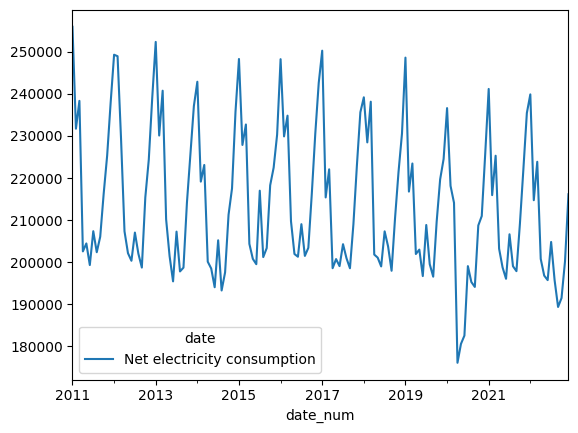

<Axes: xlabel='date_num'>

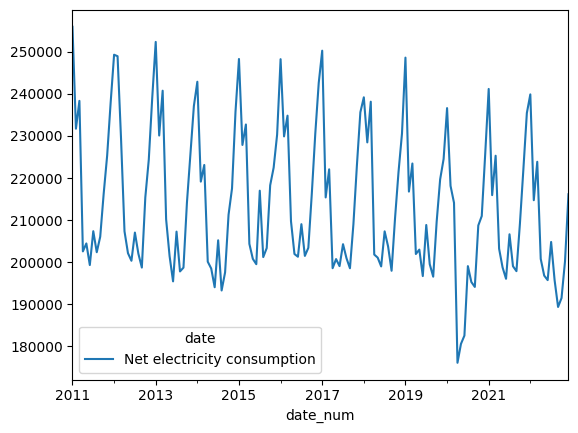

In [70]:
df_TS.plot()

In [71]:
df_TS.interpolate(inplace = True)
df_TS.index=df_TS.index.to_timestamp()

<ipython-input-35-ced2d31e58f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TS.interpolate(inplace = True)
<ipython-input-71-ced2d31e58f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TS.interpolate(inplace = True)


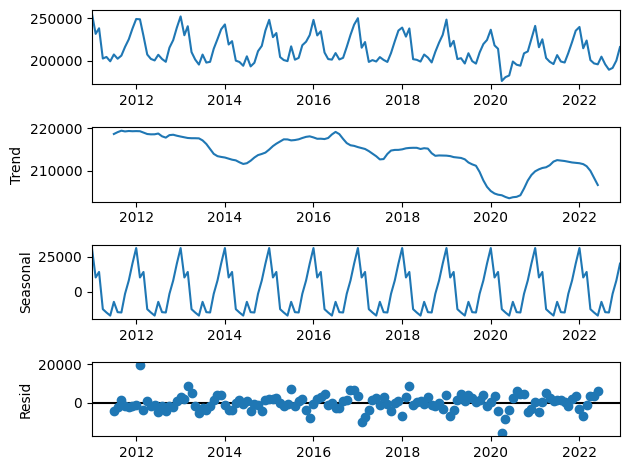

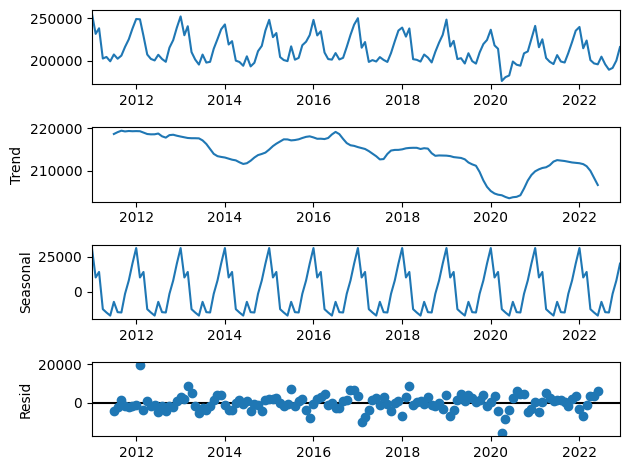

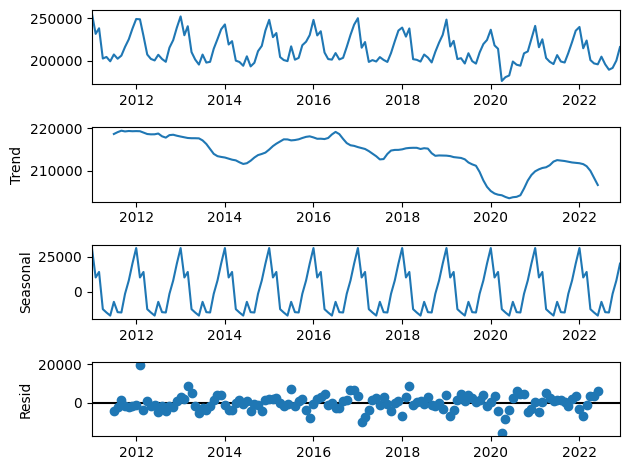

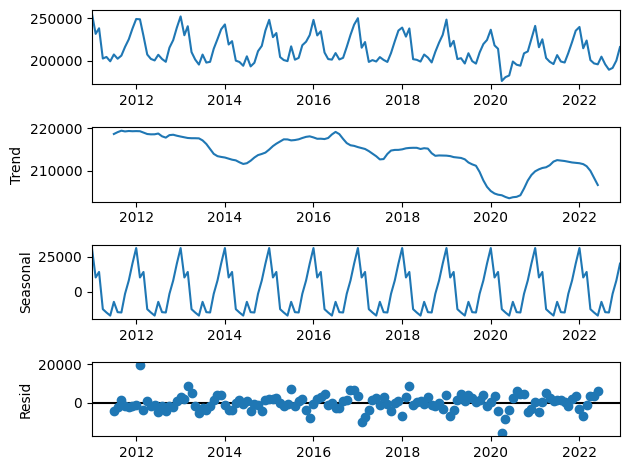

In [72]:
result = seasonal_decompose(df_TS)
result.plot()

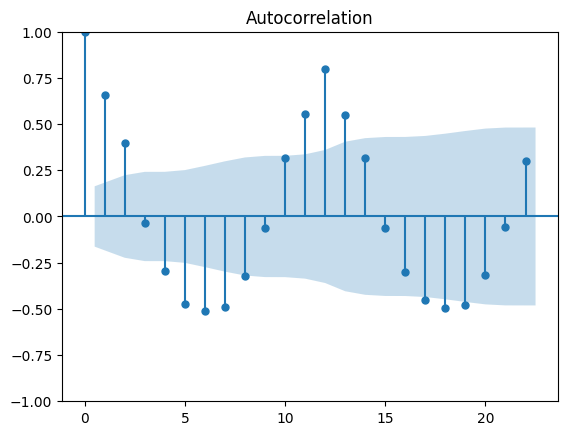

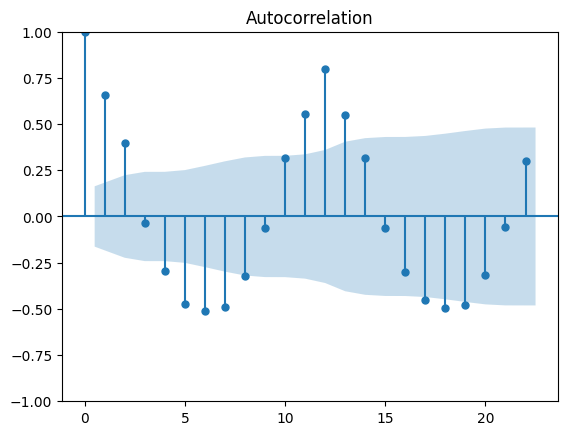

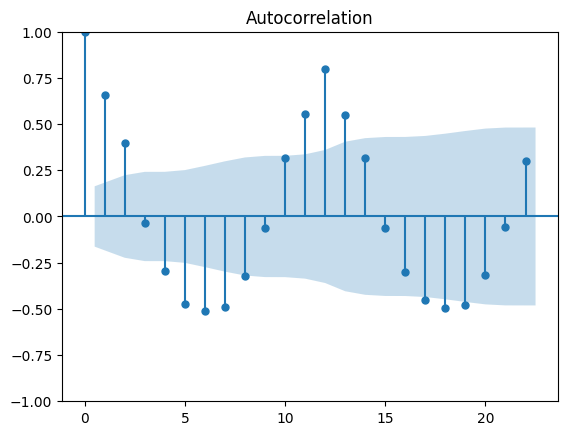

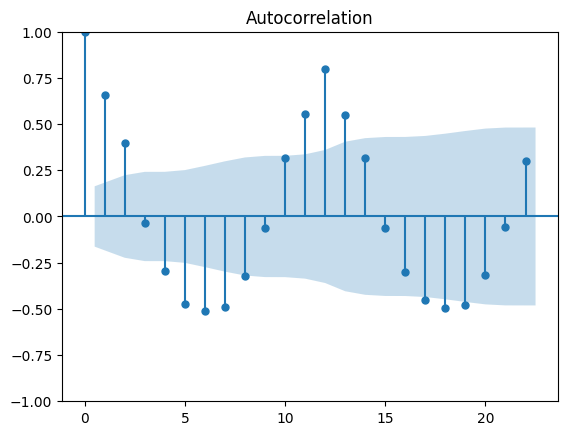

In [73]:
plot_acf(df_TS)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


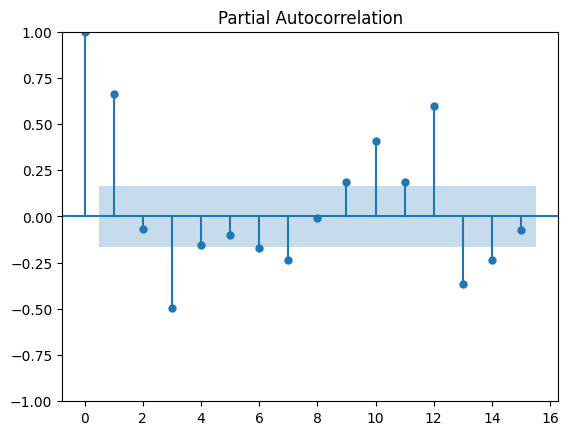

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


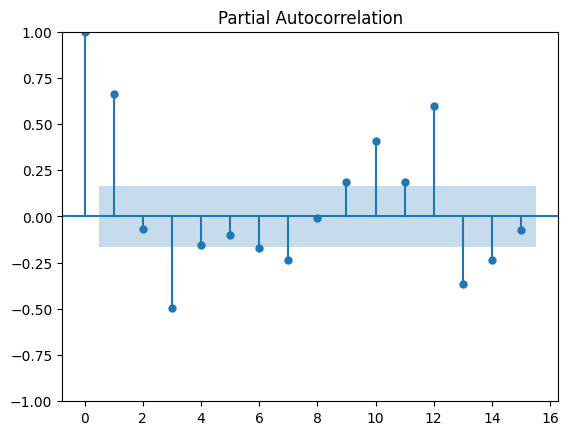

In [74]:
plot_pacf(df_TS, lags = 15)
pyplot.show()

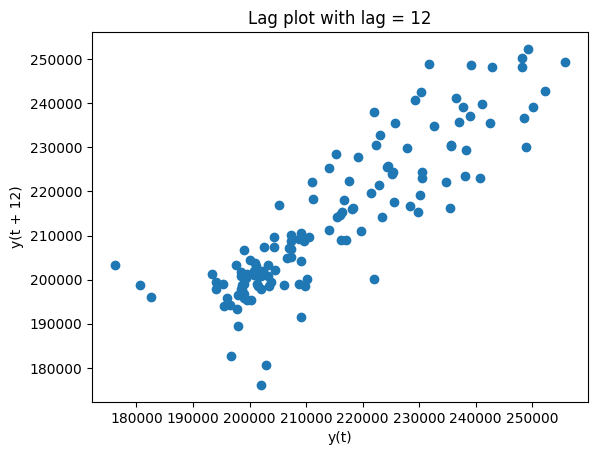

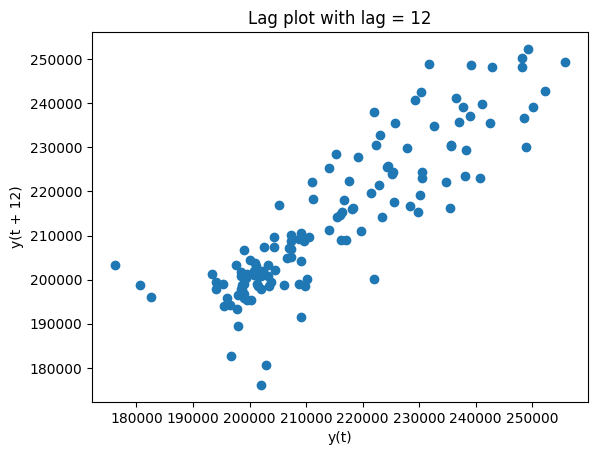

In [75]:
pd.plotting.lag_plot(df_TS, lag=12)
plt.title("Lag plot with lag = 12");
plt.show(block=True);

In [76]:
import seaborn as sns

In [77]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_TS["Net electricity consumption"].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.1383576422825357
ADF p-values: 0.6995355410133098
ADF number of lags used: 12
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2647.783563796369
ADF test statistic: -1.1383576422825357
ADF p-values: 0.6995355410133098
ADF number of lags used: 12
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2647.783563796369


Analyse result of Dickey Fuller test: Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


<Axes: xlabel='date_num'>

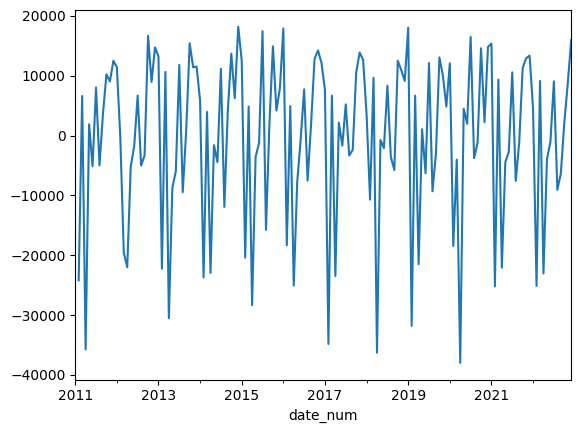

<Axes: xlabel='date_num'>

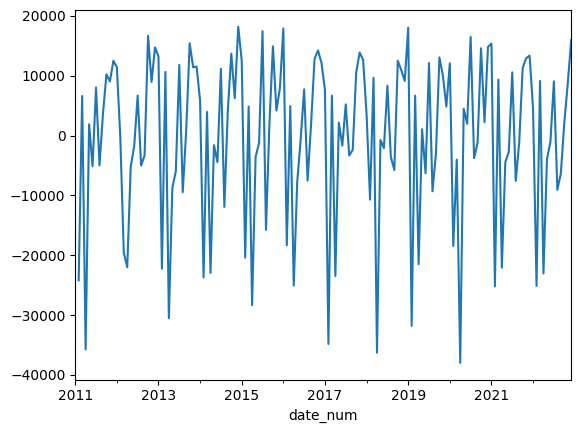

In [78]:
prev_value = df_TS["Net electricity consumption"].shift()
differenced = df_TS["Net electricity consumption"] - prev_value
differenced.plot()

In [79]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -5.862822661669426
ADF p-values: 3.379009271610905e-07
ADF number of lags used: 11
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2627.6281799033104
ADF test statistic: -5.862822661669426
ADF p-values: 3.379009271610905e-07
ADF number of lags used: 11
ADF number of observations: 131
ADF critical values: {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}
ADF best information criterion: 2627.6281799033104


The p-value is very small, indicating that the alternative hypothesis (stationarity) is true.

In [80]:
df_final.dtypes

date
Date                              object
Cooling degree days              float64
Heating degree days              float64
Net electricity consumption      float64
date_num                       period[M]
month                            float64
summer                             int64
dtype: object

date
Date                              object
Cooling degree days              float64
Heating degree days              float64
Net electricity consumption      float64
date_num                       period[M]
month                            float64
summer                             int64
dtype: object

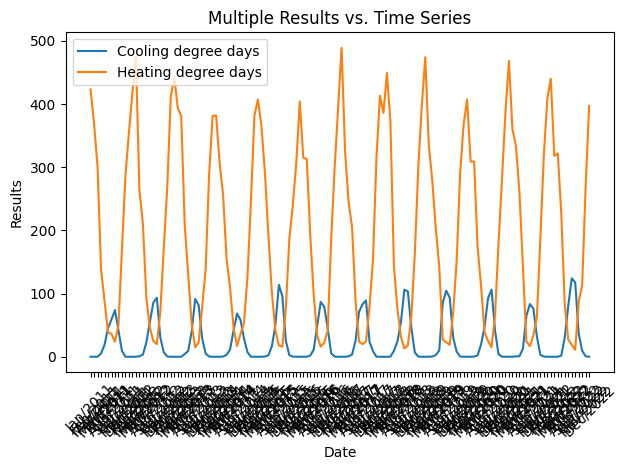

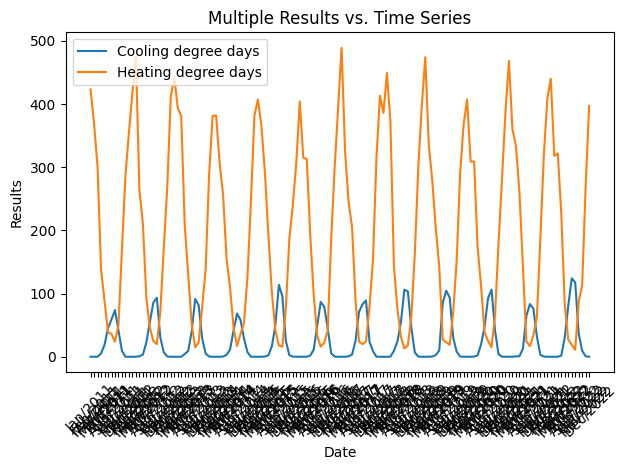

In [81]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot multiple lines on the same graph

ax.plot(df_final["Date"], df_final["Cooling degree days"], label='Cooling degree days')
ax.plot(df_final["Date"], df_final["Heating degree days"], label='Heating degree days')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Results')
ax.set_title('Multiple Results vs. Time Series')

# Show the legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Feature Engineering

In [85]:
# change column name to easier for using
df_final = df_final.rename(columns={"Net electricity consumption": "elec", "Cooling degree days": "CDD", "Heating degree days":"HDD"})

**create variable lag net electricity consumption**

In [88]:
#create variable lag net electricity consumption
df_final["elec_lag12"] = df_final.elec.shift(12)
df_final = df_final.dropna(subset=['elec_lag12'])

In [89]:
df_final

date,Date,CDD,HDD,elec,date_num,month,summer,elec_lag12
49,Jan/2012,0.00,418.0,249273.000,2012-01,0.000000,0,255910.000
37,Feb/2012,0.00,476.0,248920.000,2012-02,0.083333,0,231708.000
85,Mar/2012,0.81,264.0,229357.000,2012-03,0.166667,0,238319.000
1,Apr/2012,3.38,211.0,207344.000,2012-04,0.250000,1,202572.000
97,May/2012,22.77,93.0,202150.000,2012-05,0.333333,1,204460.000
...,...,...,...,...,...,...,...,...
23,Aug/2022,117.52,11.0,195744.016,2022-08,0.583333,1,199054.298
143,Sep/2022,36.45,87.0,189375.178,2022-09,0.666667,1,197878.682
131,Oct/2022,9.50,113.0,191494.594,2022-10,0.750000,1,209142.343
119,Nov/2022,0.74,271.0,200189.560,2022-11,0.833333,0,222074.199
